In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import time
import matplotlib.animation as animation
from IPython.display import HTML


class FHN_PDE_Simulator:
    """
    Symulator 2D modelu FitzHugh-Nagumo (PDE)
    Obsługuje dwa solwery: 'euler' (FTCS) i 'rk4' (Runge-Kutta 4).
    """
    def __init__(self, size=100, dt=0.01, dx=1.0, Du=1.0, Dv=0.5, 
                 a=0.1, b=0.5, epsilon=0.01, solver='euler', bc='wrap', noise_amp=0.01):
        
        self.size = size
        self.dt = dt
        self.dx = dx
        
        # Parametry modelu
        self.Du = Du
        self.Dv = Dv
        self.a = a
        self.b = b
        self.epsilon = epsilon
        
        # Wybór solwera
        if solver not in ['euler', 'rk4']:
            raise ValueError("Solver musi być 'euler' lub 'rk4'")
        self.solver_name = solver
        
        # BC dla convolve2d: 'wrap' (periodic) lub 'symm' (odbicie ~ Neumann)
        self.bc = bc
        
        # Dyskretny kernel Laplace'a
        self.laplacian_kernel = np.array([[0, 1, 0],
                                           [1, -4, 1],
                                           [0, 1, 0]]) / (self.dx**2)
        
        self.u = np.zeros((size, size))
        self.v = np.zeros((size, size))
        self.noise_amp = noise_amp
        
        self.set_initial_conditions()
        
        # prosty check stabilności (dla explicite FTCS)
        maxD = max(self.Du, max(self.Dv, 1e-12))
        stable_dt = (self.dx**2) / (4.0 * maxD)
        if self.solver_name == 'euler' and self.dt > stable_dt:
            print(f"UWAGA: dt={self.dt:.4e} może być niestabilne dla D={maxD:.3f} (est. dt<= {stable_dt:.4e}).")
            

    def set_initial_conditions(self, type='spiral'):
        """Ustawia warunki początkowe dla fal spiralnych."""
        self.u.fill(0)
        self.v.fill(0)
        
        N = self.size
        
        if type == 'block':
            self.u[N//4:N//2, N//4:N//2] = 1.0
            
        elif type == 'spiral_obstacle':
            # 1. Fala prosta z lewej strony
            self.u[:, :N//4] = 1.0
            
            # 2. Region inhibitora w kształcie litery C w środku
            # Zwiększamy wartość v w regionie przeszkody
            start_x, start_y = N//3, N//3
            width, height = N//3, N//3
            thickness = N//15  # Grubość "ścianek" C
            
            # Rysujemy kształt C - zewnętrzny prostokąt
            self.v[start_y:start_y+height, start_x:start_x+width] = 0.2  # Wysoki inhibitor
            
            # Wycinamy środek, tworząc C
            inner_start_x = start_x + thickness
            inner_start_y = start_y + thickness
            inner_width = width - 2 * thickness
            self.v[inner_start_y:start_y+height, 
                inner_start_x:inner_start_x+inner_width] = 0.0  # Brak inhibitora w środku
            
        elif type == 'spiral':
            # dolna połowa + mała przerwa
            self.u[N//2:, :] = 1.0
            gap = N // 12
            center = N//2
            self.u[center:center+gap, center-gap//2:center+gap//2] = 0.0
            self.v[N//2:, :] = 0.5

        elif type == 'spiral_v2':
            # L-shape z przerwą w rogu — typowy setup dla spiral
            half = N//2
            thickness = max(2, N//20)
            gap = max(2, N//18)
            # pionowy segment (lewa połowa)
            self.u[half: , :half] = 1.0
            # poziomy segment (dolna połowa)
            self.u[half:half+thickness, :] = 1.0
            # wytnij mały gap w rogu, żeby utworzyć wolny koniec
            self.u[half:half+gap, half-gap:half] = 0.0
            self.v[...] = 0.0
            self.v[half:half+gap, half-gap:half] = 1.0

        elif type == 'spiral_v3':
            """
            spiralna fala na poczatku w ksztalcie muszelki (spirala logarytmiczna?)
            """
            x = np.linspace(-1, 1, N)
            y = np.linspace(-1, 1, N)
            X, Y = np.meshgrid(x, y)
            theta = np.arctan2(Y, X)
            r = np.sqrt(X**2 + Y**2)
            spiral_condition = (r < 0.35 + 0.08 * theta) & (theta > -np.pi) & (r > 0.05)
            self.u[spiral_condition] = 1.0
            self.v[spiral_condition] = 0.0
        
        elif type == 'circle_inhib':
            """
            inhibitor w ksztalcie kółeczka
            """
            # 1. Fala prosta z lewej strony
            self.u[:, :N//4] = 1.0
            
            x = np.linspace(-1, 1, N)
            y = np.linspace(-1, 1, N)
            X, Y = np.meshgrid(x, y)
            theta = np.arctan2(Y, X)
            r = np.sqrt(X**2 + Y**2)
            spiral_condition = (r < 0.28)
            self.v[spiral_condition] = 0.15
            
        elif type == 'circle_inhibv2':
            """
            inhibitor w ksztalcie kółeczka
            """
            # 1. Fala prosta z lewej strony
            self.u[:, :N//4] = 1.0
            
            x = np.linspace(-1, 1, N)
            y = np.linspace(-1, 1, N)
            X, Y = np.meshgrid(x, y)
            theta = np.arctan2(Y, X)
            r = np.sqrt(X**2 + Y**2)
            spiral_condition = (r < 0.25)
            self.v[spiral_condition] = 0.15

        elif type == 'random':
            self.u = (np.random.rand(N, N) > 0.95).astype(float)
            

            
        # mały szum aby przełamać symetrię
        if self.noise_amp is not None and self.noise_amp > 0:
            self.u += self.noise_amp * np.random.randn(N, N)
            self.u = np.clip(self.u, 0.0, 1.0)

    def _laplacian(self, grid):
        """Oblicza $\nabla^2$ używając splotu (warunki brzegowe 'wrap')."""
        return convolve2d(grid, self.laplacian_kernel, mode='same', boundary='fill')

    def _reaction_term(self, u_grid, v_grid):
        """Oblicza człony reakcyjne f(u,v) i g(u,v)."""
        f_u = u_grid * (1 - u_grid) * (u_grid - self.a) - v_grid
        g_v = self.epsilon * (u_grid - self.b * v_grid)
        return f_u, g_v

    def _get_full_derivative(self, u_grid, v_grid):
        """Oblicza pełną pochodną czasową (dyfuzja + reakcja) dla RK4."""
        delta_u = self._laplacian(u_grid)
        delta_v = self._laplacian(v_grid)
        
        f_u, g_v = self._reaction_term(u_grid, v_grid)
        
        du_dt = self.Du * delta_u + f_u
        dv_dt = self.Dv * delta_v + g_v
        
        return du_dt, dv_dt

    def _step_euler(self):
        """Jeden krok solwera Eulera (FTCS)."""
        du_dt, dv_dt = self._get_full_derivative(self.u, self.v)
        self.u += self.dt * du_dt
        self.v += self.dt * dv_dt

    def _step_rk4(self):
        """Jeden krok solwera Runge-Kutta 4. rzędu."""
        # k1
        k1_u, k1_v = self._get_full_derivative(self.u, self.v)
        
        # k2
        u2 = self.u + 0.5 * self.dt * k1_u
        v2 = self.v + 0.5 * self.dt * k1_v
        k2_u, k2_v = self._get_full_derivative(u2, v2)

        # k3
        u3 = self.u + 0.5 * self.dt * k2_u
        v3 = self.v + 0.5 * self.dt * k2_v
        k3_u, k3_v = self._get_full_derivative(u3, v3)
        
        # k4
        u4 = self.u + self.dt * k3_u
        v4 = self.v + self.dt * k3_v
        k4_u, k4_v = self._get_full_derivative(u4, v4)
        
        # Złożenie
        self.u += (self.dt / 6.0) * (k1_u + 2*k2_u + 2*k3_u + k4_u)
        self.v += (self.dt / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)

    def step(self):
        """Wykonuje jeden krok symulacji wybranym solwerem."""
        if self.solver_name == 'euler':
            self._step_euler()
        elif self.solver_name == 'rk4':
            self._step_rk4()

    def run_simulation(self, steps, snapshot_interval=10, return_both=False):
            """Uruchamia symulację i zwraca historię stanów.
            
            Parametry:
                steps: liczba kroków symulacji
                snapshot_interval: co ile kroków zapisywać stan
                return_both: jeśli True, zwraca krotkę (history_u, history_v)
            """
            print(f"Uruchamiam symulację PDE (Solver: {self.solver_name}, Rozdz: {self.size}x{self.size}, Kroki: {steps})...")
            start_time = time.time()
            
            history_u = []
            history_v = [] if return_both else None
            
            for step in range(steps):
                self.step()
                if step % snapshot_interval == 0:
                    history_u.append(np.copy(self.u))
                    if return_both:
                        history_v.append(np.copy(self.v))
                    
            end_time = time.time()
            self.last_run_time = end_time - start_time
            print(f"Symulacja PDE zakończona. Czas: {self.last_run_time:.4f} s")
            
            if return_both:
                return history_u, history_v
            else:
                return history_u


In [ ]:
sim = FHN_PDE_Simulator(size=200, dt=0.02, Du=1.0, Dv=0.0, a=0.05, b=0.3, epsilon=0.005, solver='euler', noise_amp=0.02)
sim.set_initial_conditions('spiral_obstacle')

# Uruchamiamy symulację zwracając obie zmienne
history_u, history_v = sim.run_simulation(steps=40000, snapshot_interval=500, return_both=True)

Uruchamiam symulację PDE (Solver: euler, Rozdz: 200x200, Kroki: 40000)...
Symulacja PDE zakończona. Czas: 67.0879 s


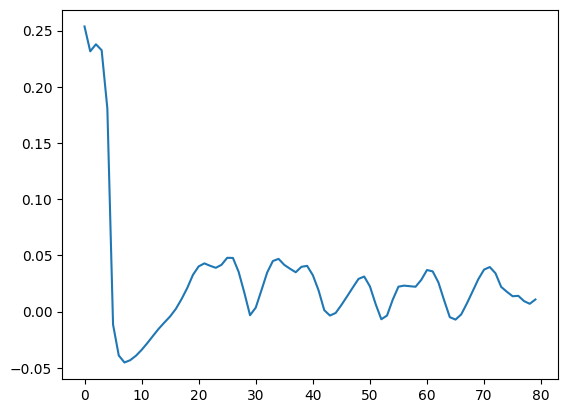

In [27]:
mean_u = np.array([np.mean(history_u[i]) for i in range(len(history_u))]).reshape(80,1)
plt.plot(mean_u)
X_train = mean_u[5:25].reshape(20,1)
Y_train = mean_u[6:26].reshape(20,1)

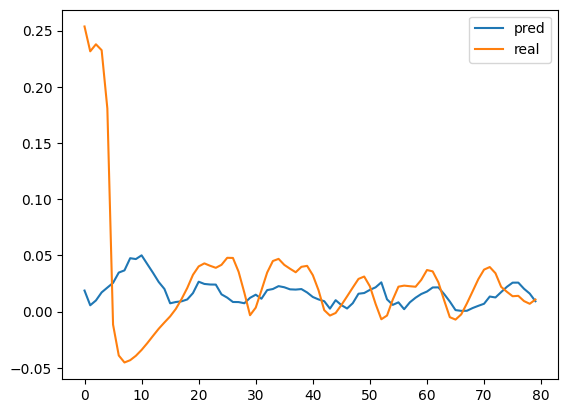

In [43]:
import reservoirpy as rpy

n_neurons = 200

reservoir = rpy.nodes.Reservoir(n_neurons, lr=0.9, sr=5.0, input_scaling=10.0)
readout = rpy.nodes.Ridge(ridge=1e-7)

model = reservoir >> readout
# model &= reservoir << readout
model.fit(X_train,Y_train,warmup=5)

mean_u = mean_u.reshape(-1,1)
pred = model.run(mean_u)

plt.plot(pred,label='pred')
plt.plot(mean_u,label='real')
plt.legend()